# Heatmapping
Since numerical explanations are not very informative at first sight,
we can visualize them by computing a `heatmap`, using either
[VisionHeatmaps.jl](https://julia-xai.github.io/XAIDocs/VisionHeatmaps/stable/) or
[TextHeatmaps.jl](https://julia-xai.github.io/XAIDocs/TextHeatmaps/stable/).

This page showcases different options and preset for heatmapping,
building on the basics shown in the *Getting started* section.

We start out by loading the same pre-trained LeNet5 model and MNIST input data:

In [1]:
using ExplainableAI
using VisionHeatmaps
using Flux

using BSON # hide
model = BSON.load("../model.bson", @__MODULE__)[:model] # hide
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

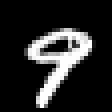

In [2]:
using MLDatasets
using ImageCore, ImageIO, ImageShow

index = 10
x, y = MNIST(Float32, :test)[10]
input = reshape(x, 28, 28, 1, :)

img = convert2image(MNIST, x)

## Automatic heatmap presets
The function `heatmap` automatically applies common presets for each method.

Since `InputTimesGradient` computes attributions,
heatmaps are shown in a blue-white-red color scheme.
Gradient methods however are typically shown in grayscale:

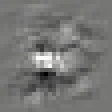

In [3]:
analyzer = Gradient(model)
heatmap(input, analyzer)

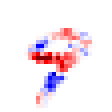

In [4]:
analyzer = InputTimesGradient(model)
heatmap(input, analyzer)

## Custom heatmap settings
### Color schemes
We can partially or fully override presets by passing keyword arguments to `heatmap`.
For example, we can use a custom color scheme from ColorSchemes.jl using the keyword argument `colorscheme`:

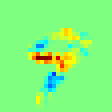

In [5]:
using ColorSchemes

expl = analyze(input, analyzer)
heatmap(expl; colorscheme=:jet)

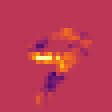

In [6]:
heatmap(expl; colorscheme=:inferno)

Refer to the [ColorSchemes.jl catalogue](https://juliagraphics.github.io/ColorSchemes.jl/stable/basics/)
for a gallery of available color schemes.

### Color channel reduction
Explanations have the same dimensionality as the inputs to the classifier.
For images with multiple color channels,
this means that the explanation also has a "color channel" dimension.

The keyword argument `reduce` can be used to reduce this dimension
to a single scalar value for each pixel.
The following presets are available:
- `:sum`: sum up color channels (default setting)
- `:norm`: compute 2-norm over the color channels
- `:maxabs`: compute `maximum(abs, x)` over the color channels

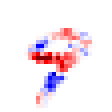

In [7]:
heatmap(expl; reduce=:sum)

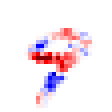

In [8]:
heatmap(expl; reduce=:norm)

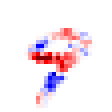

In [9]:
heatmap(expl; reduce=:maxabs)

In this example, the heatmaps look identical.
Since MNIST only has a single color channel, there is no need for color channel reduction.

### Mapping explanations onto the color scheme
To map a color-channel-reduced explanation onto a color scheme,
we first need to normalize all values to the range $[0, 1]$.

For this purpose, two presets are available through the `rangescale` keyword argument:
- `:extrema`: normalize to the minimum and maximum value of the explanation
- `:centered`: normalize to the maximum absolute value of the explanation.
  Values of zero will be mapped to the center of the color scheme.

Depending on the color scheme, one of these presets may be more suitable than the other.
The default color scheme for `InputTimesGradient`, `seismic`, is centered around zero,
making `:centered` a good choice:

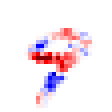

In [10]:
heatmap(expl; rangescale=:centered)

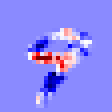

In [11]:
heatmap(expl; rangescale=:extrema)

However, for the `inferno` color scheme, which is not centered around zero,
`:extrema` leads to a heatmap with higher contrast.

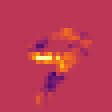

In [12]:
heatmap(expl; rangescale=:centered, colorscheme=:inferno)

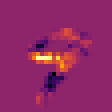

In [13]:
heatmap(expl; rangescale=:extrema, colorscheme=:inferno)

For the full list of `heatmap` keyword arguments, refer to the `heatmap` documentation.

## Heatmap overlays
Heatmaps can be overlaid onto the input image using the `heatmap_overlay` function
from VisionHeatmaps.jl.
This can be useful for visualizing the relevance of specific regions of the input:

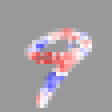

In [14]:
heatmap_overlay(expl, img)

The alpha value of the heatmap can be adjusted using the `alpha` keyword argument:

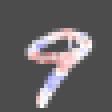

In [15]:
heatmap_overlay(expl, img; alpha=0.3)

All previously discussed keyword arguments for `heatmap` can also be used with `heatmap_overlay`:

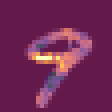

In [16]:
heatmap_overlay(expl, img; alpha=0.7, colorscheme=:inferno, rangescale=:extrema)

## Heatmapping batches
Heatmapping also works with input batches.
Let's demonstrate this by using a batch of 25 images from the MNIST dataset:

In [17]:
xs, ys = MNIST(Float32, :test)[1:25]
batch = reshape(xs, 28, 28, 1, :); # reshape to WHCN format

The `heatmap` function automatically recognizes
that the explanation is batched and returns a `Vector` of images:

,,,,,,,,,,,,,,,,,,,,,,,,

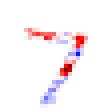
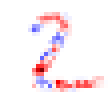
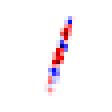
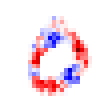
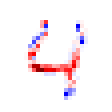
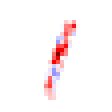
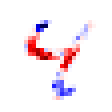
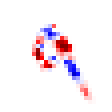
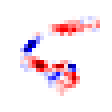
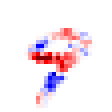
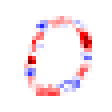
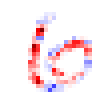
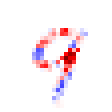
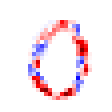
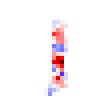
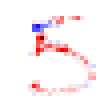
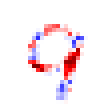
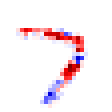
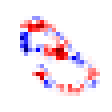
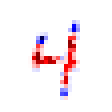
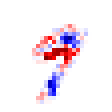
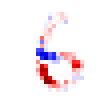
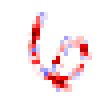
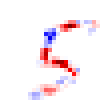
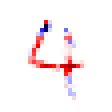

In [18]:
heatmaps = heatmap(batch, analyzer)

Image.jl's `mosaic` function can used to display them in a grid:

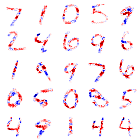

In [19]:
mosaic(heatmaps; nrow=5)

When heatmapping batches, the mapping to the color scheme is applied per sample.
For example, `rangescale=:extrema` will normalize each heatmap
to the minimum and maximum value of each sample in the batch.
This ensures that heatmaps don't depend on other samples in the batch.

If this bevahior is not desired,
`heatmap` can be called with the keyword-argument `process_batch=true`:

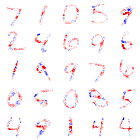

In [20]:
expl = analyze(batch, analyzer)
heatmaps = heatmap(expl; process_batch=true)
mosaic(heatmaps; nrow=5)

This can be useful when comparing heatmaps for fixed output neurons:

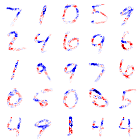

In [21]:
expl = analyze(batch, analyzer, 7) # explain digit "6"
heatmaps = heatmap(expl; process_batch=true)
mosaic(heatmaps; nrow=5)

## Processing heatmaps
Heatmapping makes use of the
[Julia-based image processing ecosystem Images.jl](https://github.com/JuliaImages).

If you want to further process heatmaps, you may benefit from reading about some
[fundamental conventions](https://juliaimages.org/latest/tutorials/quickstart/)
that the ecosystem utilizes that are different from how images are typically represented
in OpenCV, MATLAB, ImageJ or Python.

## Saving heatmaps
Since heatmaps are regular Images.jl images, they can be saved as such:
```julia
using FileIO

img = heatmap(input, analyzer)
save("heatmap.png", img)
```

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*